## Part A - What does orthogonal diagonalization really mean?

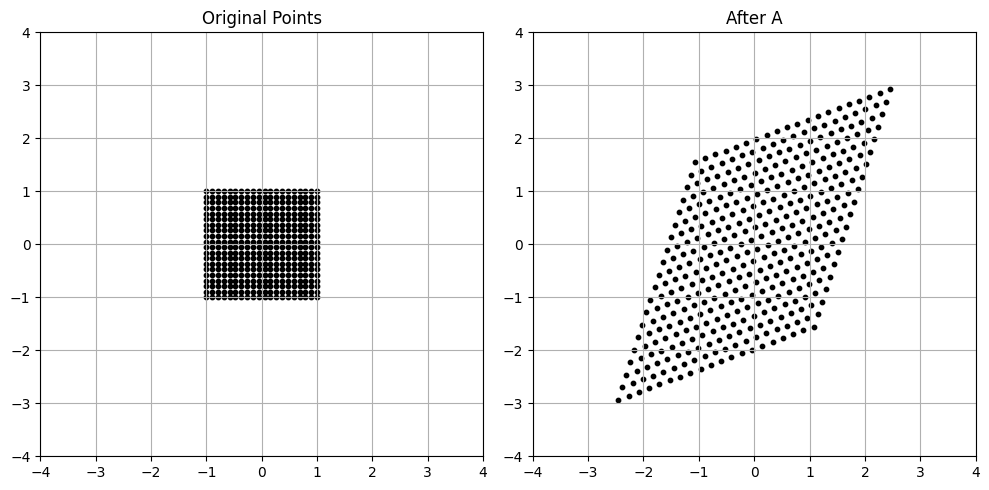

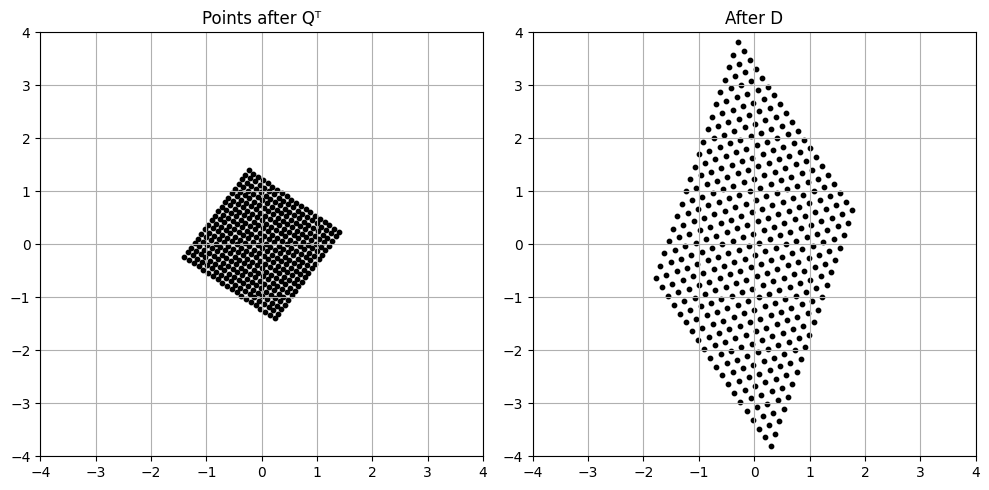

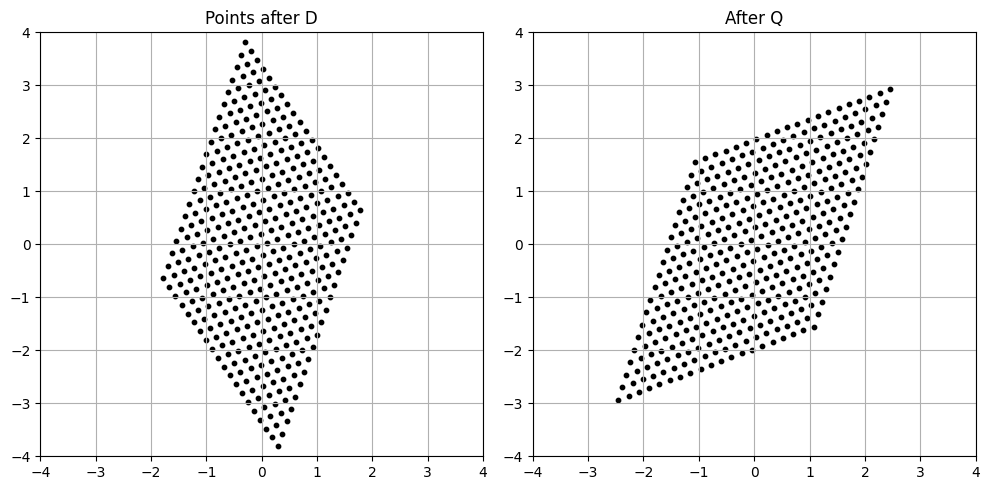

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Generate a random symmetric matrix A
np.random.seed(0)
M = np.random.randn(2, 2)
A = (M + M.T) / 2

# 2. Orthogonal diagonalization: A = Q D Q^T
eigenvalues, Q = np.linalg.eigh(A)
D = np.diag(eigenvalues)
QT = Q.T

# 3. Define a grid of points around the origin
x = np.linspace(-1, 1, 20)
y = np.linspace(-1, 1, 20)
xx, yy = np.meshgrid(x, y)
points = np.vstack([xx.ravel(), yy.ravel()]).T

# 4. Perform each transformation
points_A   = points.dot(A.T)
points_QT  = points.dot(Q)
points_D   = points_QT.dot(D)
points_Q   = points_D.dot(Q.T)

# 5. Plotting: for each step, show before/after in side-by-side subplots

def plot_pair(before, after, title_before, title_after,xlim=(-4, 4), ylim=(-4, 4)):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].scatter(before[:, 0], before[:, 1], s=10, color='black')
    axs[0].set_title(title_before)
    axs[0].set_xlim(xlim)
    axs[0].set_ylim(ylim)
    axs[0].grid(True)
    axs[1].scatter(after[:, 0], after[:, 1], s=10, color='black')
    axs[1].set_title(title_after)
    axs[1].set_xlim(xlim)
    axs[1].set_ylim(ylim)
    axs[1].grid(True)
    plt.tight_layout()
    plt.show()

# A
plot_pair(points, points_A, 'Original Points', 'After A')

# Qᵀ
plot_pair(points, points_QT, 'Original Points', 'After Qᵀ')

# D
plot_pair(points_QT, points_D, 'Points after Qᵀ', 'After D')

# Q
plot_pair(points_D, points_Q, 'Points after D', 'After Q')


In [ ]:
import numpy as np

def random_symmetric(n: int = 3, seed=None) -> np.ndarray:
    """Return an n×n real‑symmetric matrix with N(0,1) entries."""
    rng = np.random.default_rng(seed)
    M = rng.standard_normal((n, n))
    return (M + M.T) / 2

def diagonalize(A: np.ndarray):
    """Return Q (orthogonal) and eigenvalue 1‑D array D so that A = Q diag(D) Qᵀ."""
    eigvals, Q = np.linalg.eigh(A)          # guaranteed real & sorted asc.
    return Q, eigvals

def check_factorization(A, Q, D,):
    """Frobenius‑norm errors for reconstruction and orthogonality."""
    A_hat = Q @ np.diag(D) @ Q.T
    err_reconstruct = np.linalg.norm(A - A_hat, ord='fro')
    err_orth        = np.linalg.norm(Q.T @ Q - np.eye(A.shape[0]), ord='fro')
    return err_reconstruct, err_orth

# %% Generate and test three matrices
rng = np.random.default_rng(42)
for i in range(3):
    A = random_symmetric(3, seed=rng)
    Q, D = diagonalize(A)
    err_rec, err_orth = check_factorization(A, Q, D)
    print(f"Matrix {i+1}: reconstruction error {err_rec:.2e}, orthogonality error {err_orth:.2e}")
    print(f"Matrix {i+1}:\n", A, "\n")  
    print("  eigenvalues =", np.round(D, 2), "\n")


Matrix 1: reconstruction error 1.26e-15, orthogonality error 6.53e-16
Matrix 1:
 [[ 0.30471708 -0.04970969  0.4391458 ]
 [-0.04970969 -1.95103519 -0.80921105]
 [ 0.4391458  -0.80921105 -0.01680116]] 

  eigenvalues = [ 0.72 -0.14 -2.25] 

Matrix 2: reconstruction error 1.00e-15, orthogonality error 6.45e-16
Matrix 2:
 [[-0.85304393  0.47271434 -0.04075026]
 [ 0.47271434  1.12724121  0.41813006]
 [-0.04075026  0.41813006 -0.9588826 ]] 

  eigenvalues = [ 1.3  -0.86 -1.13] 

Matrix 3: reconstruction error 6.43e-16, orthogonality error 5.89e-16
Matrix 3:
 [[ 0.8784503  -0.36542773 -0.30659509]
 [-0.36542773  1.22254134 -0.25333152]
 [-0.30659509 -0.25333152  0.53230919]] 

  eigenvalues = [0.19 0.99 1.46] 



## Part B

In [53]:
import numpy as np
import matplotlib.pyplot as plt

def build_symmetric_from_eigen(Q, eigs):
    """
    Constructs a symmetric matrix A = Q D Qᵀ given orthonormal eigenvectors Q and eigenvalues.
    Assumes Q is 2x2 and orthonormal.
    """
    D = np.diag(eigs)
    A = Q @ D @ Q.T
    return A

# --- Provide your own eigenvectors (must be orthonormal) ---
# Example: 45-degree rotation
theta = np.pi / 4
Q = np.array([[0, 1],
              [1, 0]])  # swaps x and y


eigs = [1, 2]  # Try [3, -1] for hyperbolic

# --- Build matrix from given eigenvectors and eigenvalues ---
A = build_symmetric_from_eigen(Q, eigs)

# --- Set up grid for both views ---
grid_range = np.linspace(-2, 2, 300)
xx, yy = np.meshgrid(grid_range, grid_range)
pts_xy = np.stack((xx, yy), axis=-1)  # shape (300,300,2)

# --- Cartesian View: f(x) = xᵀ A x ---
f_cartesian = np.einsum('...i,ij,...j->...', pts_xy, A, pts_xy)

# --- Eigenbasis View: x = u·q1 + v·q2 ---
flat_uv = pts_xy.reshape(-1, 2)           # treat x, y as u, v
basis = Q[:, :2]                          # eigenvectors
X = flat_uv[:, 0:1]*basis[:, 0] + flat_uv[:, 1:2]*basis[:, 1]  # x = u q1 + v q2
f_eigen = np.einsum('ni,ij,nj->n', X, A, X).reshape(xx.shape)

# --- Plot side by side ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

levels = np.linspace(min(f_cartesian.min(), f_eigen.min()), max(f_cartesian.max(), f_eigen.max()), 30)

axes[0].contour(xx, yy, f_cartesian, levels=levels)
axes[0].set_title("Cartesian coordinates $(x_1, x_2)$")
axes[0].set_xlabel("$x_1$")
axes[0].set_ylabel("$x_2$")
axes[0].set_aspect('equal')

axes[1].contour(xx, yy, f_eigen, levels=levels)
axes[1].set_title("Eigenbasis coordinates $(u, v)$")
axes[1].set_xlabel("$u$")
axes[1].set_ylabel("$v$")
axes[1].set_aspect('equal')

plt.suptitle("Quadratic Form $f(x) = x^T A x$ — Cartesian vs Eigenbasis", y=1.02)
plt.show()
print(Q)


[[0 1]
 [1 0]]



Tilted ellipse
  f(x) = 3.00·x₁² + 2·1.50·x₁·x₂ + 1.00·x₂²
  g(y) = 0.20·y₁² + 3.80·y₂²


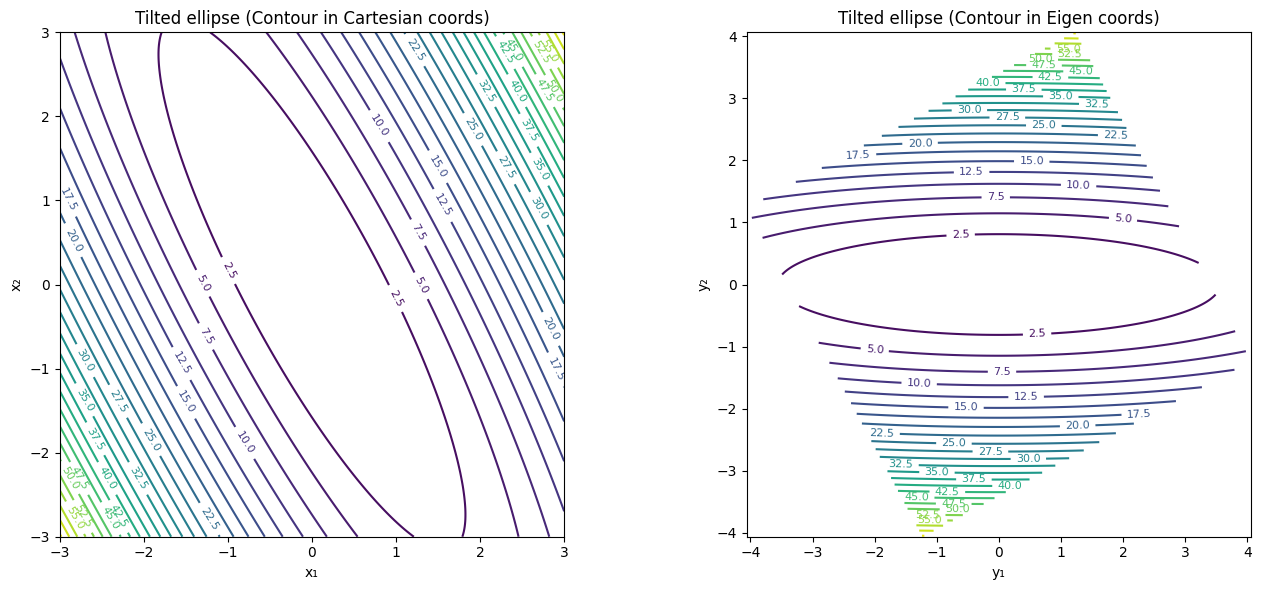

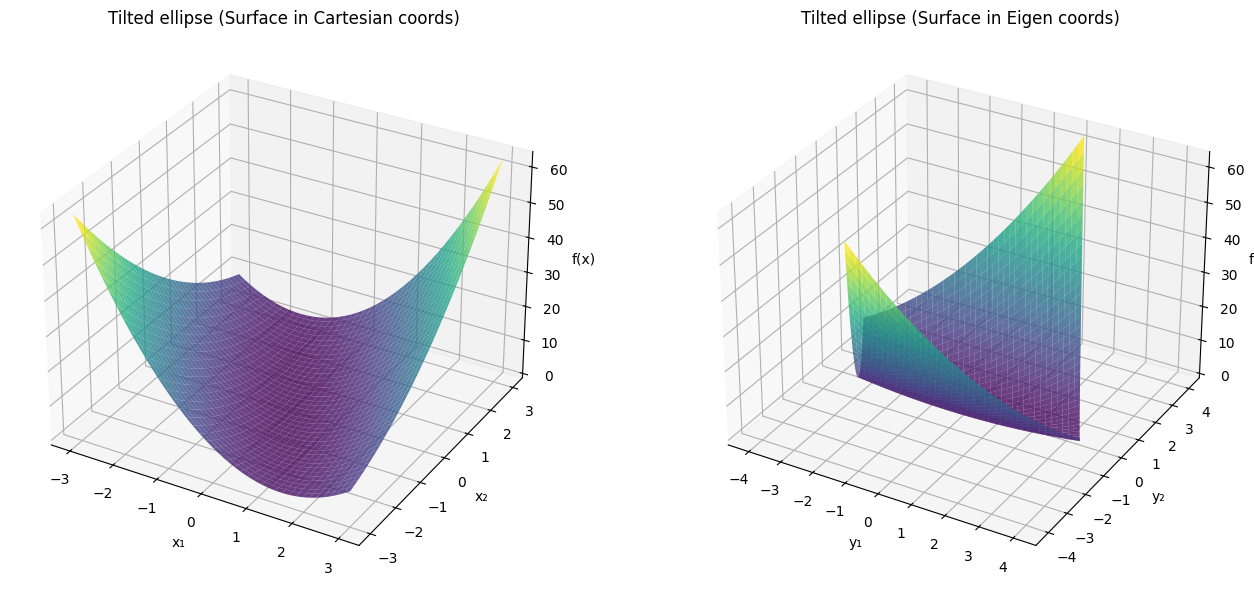


Circle
  f(x) = 2.00·x₁² + 2·0.00·x₁·x₂ + 2.00·x₂²
  g(y) = 2.00·y₁² + 2.00·y₂²


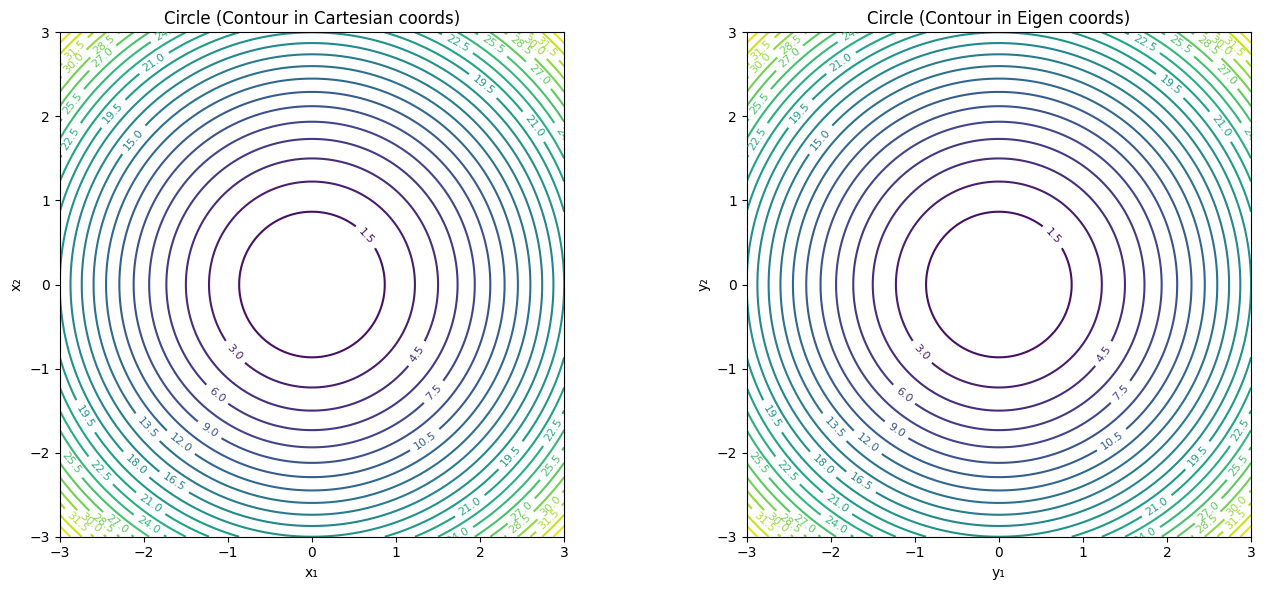


Saddle
  f(x) = 1.00·x₁² + 2·2.00·x₁·x₂ + -1.00·x₂²
  g(y) = -2.24·y₁² + 2.24·y₂²


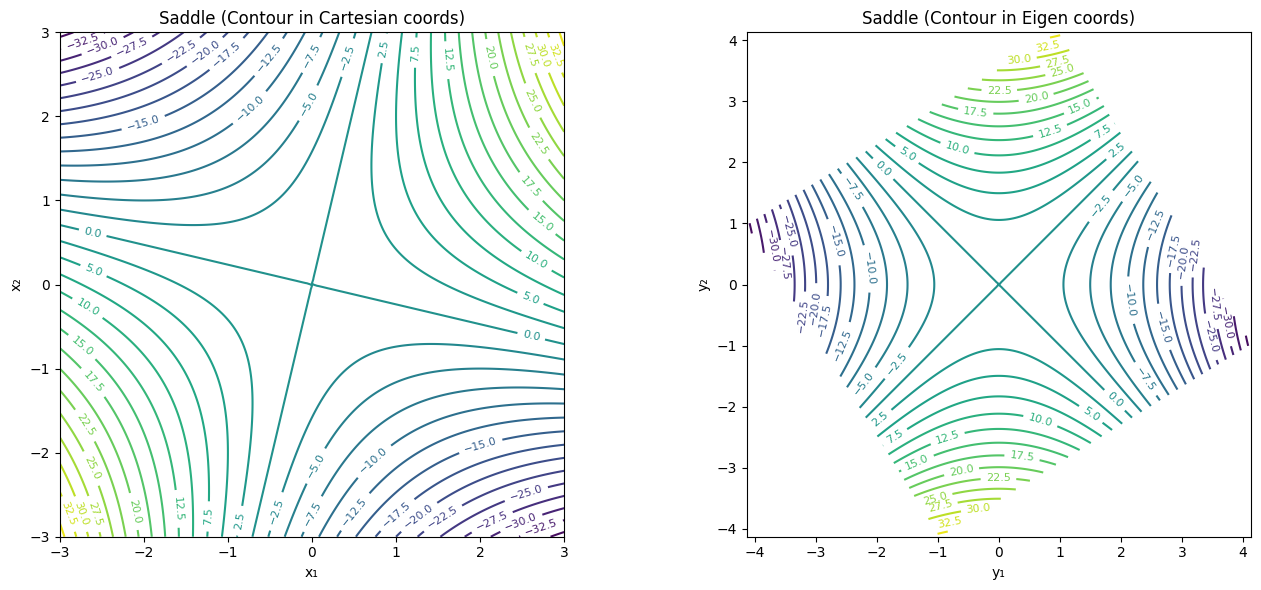

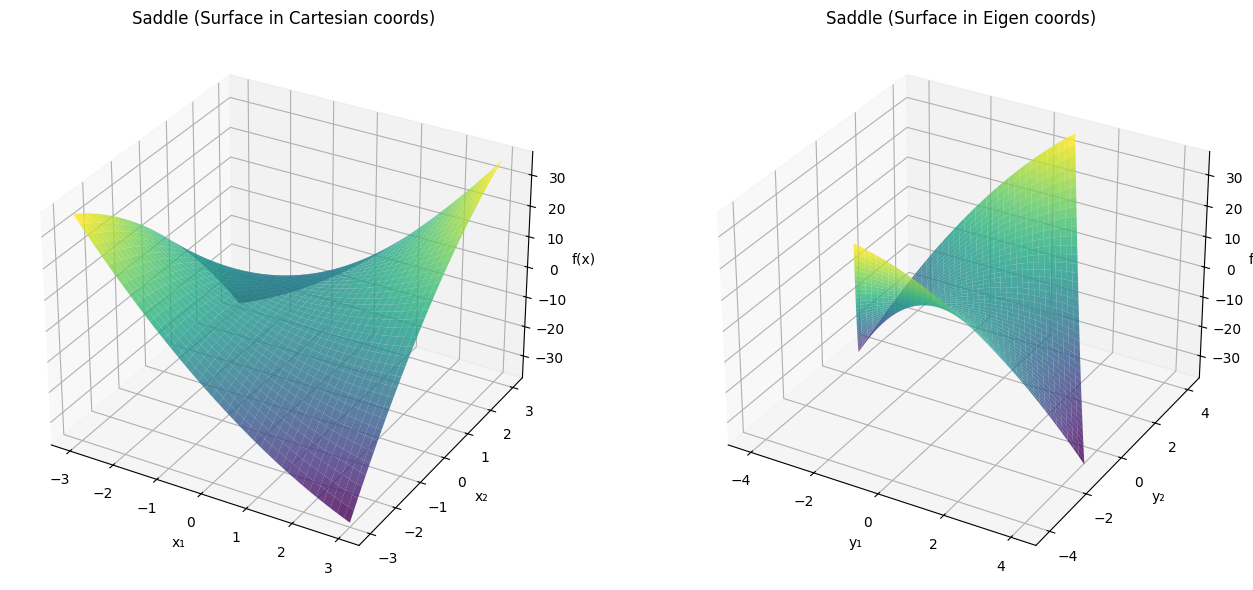

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define test matrices
mats = {
    "Tilted ellipse": np.array([[3.0, 1.5],
                                [1.5, 1.0]]),
    "Circle":         np.array([[2.0, 0.0],
                                [0.0, 2.0]]),  # λ1=λ2
    "Saddle":         np.array([[1.0, 2.0],
                                [2.0,-1.0]])   # indefinite
}

# Create a grid of points in 2D
x_lin = np.linspace(-3, 3, 200)
xx, yy = np.meshgrid(x_lin, x_lin)
pts = np.stack((xx, yy), axis=-1)  # shape (200,200,2)

# Loop through each matrix and plot in both bases
for name, A in mats.items():
    # Eigen-decomposition
    eigvals, Q = np.linalg.eigh(A)
    D = np.diag(eigvals)

    # Display symbolic forms
    a, b, c = A[0, 0], A[0, 1], A[1, 1]
    λ1, λ2 = eigvals
    print(f"\n{name}")
    print(f"  f(x) = {a:.2f}·x₁² + 2·{b:.2f}·x₁·x₂ + {c:.2f}·x₂²")
    print(f"  g(y) = {λ1:.2f}·y₁² + {λ2:.2f}·y₂²")

    # --- Cartesian coordinates ---
    f_vals = np.einsum('...i,ij,...j->...', pts, A, pts)

    # --- Eigen coordinates ---
    pts_flat = pts.reshape(-1, 2)
    y_flat = pts_flat @ Q
    y_pts = y_flat.reshape(pts.shape)
    f_vals_eig = np.einsum('...i,ij,...j->...', y_pts, D, y_pts)
    yy1 = y_pts[..., 0]
    yy2 = y_pts[..., 1]

    # --- 2D Contour Plots ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    cs1 = ax1.contour(xx, yy, f_vals, levels=30)
    ax1.clabel(cs1, inline=1, fontsize=8)
    ax1.set_title(f"{name} (Contour in Cartesian coords)")
    ax1.set_xlabel("x₁")
    ax1.set_ylabel("x₂")
    ax1.set_aspect('equal')

    cs2 = ax2.contour(yy1, yy2, f_vals_eig, levels=30)
    ax2.clabel(cs2, inline=1, fontsize=8)
    ax2.set_title(f"{name} (Contour in Eigen coords)")
    ax2.set_xlabel("y₁")
    ax2.set_ylabel("y₂")
    ax2.set_aspect('equal')

    plt.tight_layout()
    plt.show()

    # --- 3D Surface Plots ---
    fig = plt.figure(figsize=(14, 6))

    ax3 = fig.add_subplot(1, 2, 1, projection='3d')
    ax3.plot_surface(xx, yy, f_vals, rstride=5, cstride=5, alpha=0.8, cmap='viridis')
    ax3.set_title(f"{name} (Surface in Cartesian coords)")
    ax3.set_xlabel("x₁")
    ax3.set_ylabel("x₂")
    ax3.set_zlabel("f(x)")

    ax4 = fig.add_subplot(1, 2, 2, projection='3d')
    ax4.plot_surface(yy1, yy2, f_vals_eig, rstride=5, cstride=5, alpha=0.8, cmap='viridis')
    ax4.set_title(f"{name} (Surface in Eigen coords)")
    ax4.set_xlabel("y₁")
    ax4.set_ylabel("y₂")
    ax4.set_zlabel("f(y)")

    plt.tight_layout()
    plt.show()


## Part C

A =
 [[ 0.30471708 -0.14476646]
 [-0.14476646  0.94056472]]


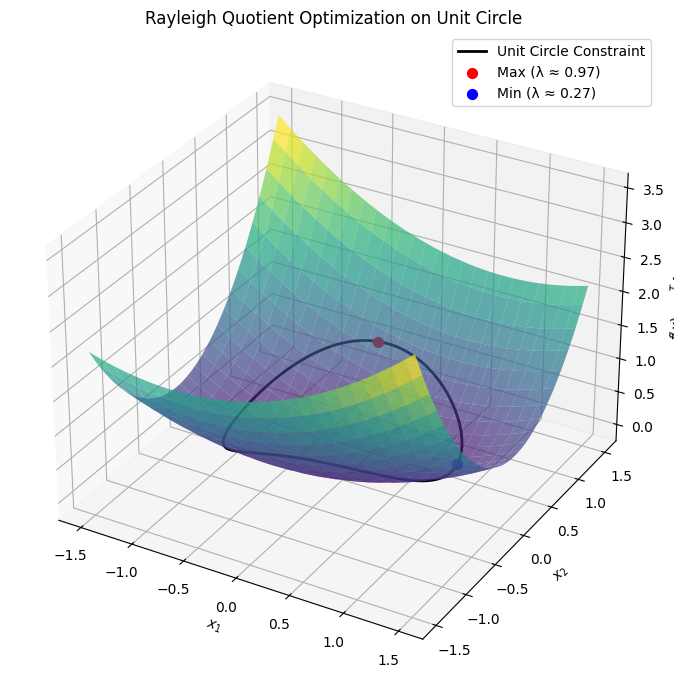

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D

# --- Helper Functions ---
def random_symmetric(n=2, seed=None):
    rng = np.random.default_rng(seed)
    M = rng.standard_normal((n, n))
    return (M + M.T) / 2  # Ensure symmetry

def rayleigh_quotient(x, A):
    return x @ A @ x

def unit_constraint(x):
    return np.sum(x**2) - 1.0  # ||x||^2 = 1

def optimise_rayleigh(A, which="max", attempts=5, seed=None):
    rng = np.random.default_rng(seed)
    n = A.shape[0]
    best_val = -np.inf if which == "max" else np.inf
    best_x = None

    # Choose objective: maximize or minimize Rayleigh quotient
    target = lambda x: -rayleigh_quotient(x, A) if which == "max" else rayleigh_quotient(x, A)

    for _ in range(attempts):
        x0 = rng.standard_normal(n)
        x0 /= np.linalg.norm(x0)
        cons = [{'type': 'eq', 'fun': unit_constraint}]
        res = minimize(target, x0, constraints=cons, method="SLSQP",
                       options={'ftol': 1e-12, 'maxiter': 500})
        if res.success:
            val = rayleigh_quotient(res.x, A)
            if (which == "max" and val > best_val) or (which == "min" and val < best_val):
                best_val = val
                best_x = res.x / np.linalg.norm(res.x)

    return best_x, best_val

# --- Generate Random Symmetric Matrix ---
A = random_symmetric(2, seed=42)
print("A =\n", A)

# --- Optimize Rayleigh Quotient on Unit Circle ---
x_max, r_max = optimise_rayleigh(A, which="max", seed=1)
x_min, r_min = optimise_rayleigh(A, which="min", seed=2)

# --- Prepare Grid for 3D Surface Plot ---
x_lin = np.linspace(-1.5, 1.5, 100)
xx, yy = np.meshgrid(x_lin, x_lin)
pts = np.stack((xx, yy), axis=-1)
f_vals = np.einsum('...i,ij,...j->...', pts, A, pts)

# --- Compute Rayleigh Quotient over the unit circle ---
theta = np.linspace(0, 2 * np.pi, 300)
circle_pts = np.stack((np.cos(theta), np.sin(theta)), axis=-1)  # shape (300, 2)
circle_vals = np.einsum('ni,ij,nj->n', circle_pts, A, circle_pts)

# --- Plot the Surface and Mark Extrema + Circle ---
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
ax.plot_surface(xx, yy, f_vals, rstride=4, cstride=4, alpha=0.7, cmap='viridis')

# Unit circle path in 3D
ax.plot(circle_pts[:, 0], circle_pts[:, 1], circle_vals, color='black', linewidth=2, label='Unit Circle Constraint')

# Mark optimizer points
ax.scatter(*x_max, r_max, color='red', s=50, label=f'Max (λ ≈ {r_max:.2f})')
ax.scatter(*x_min, r_min, color='blue', s=50, label=f'Min (λ ≈ {r_min:.2f})')

# Labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f(x) = x^T A x$')
ax.set_title('Rayleigh Quotient Optimization on Unit Circle')
ax.legend()
plt.tight_layout()
plt.show()


In [58]:
np.linalg.eig(A)

EigResult(eigenvalues=array([0.27330885, 0.97197295]), eigenvectors=array([[-0.97726419,  0.21202522],
       [-0.21202522, -0.97726419]]))

A =
 [[ 0.30471708 -0.04970969  0.4391458 ]
 [-0.04970969 -1.95103519 -0.80921105]
 [ 0.4391458  -0.80921105 -0.01680116]]


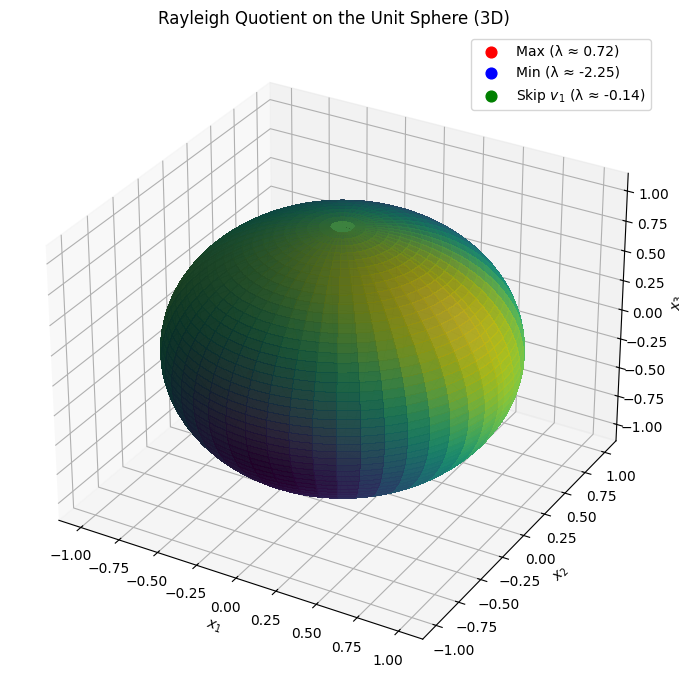

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D

# Helpers
def random_symmetric(n=3, seed=None):
    rng = np.random.default_rng(seed)
    M = rng.standard_normal((n, n))
    return (M + M.T) / 2

def rayleigh_quotient(x, A):
    return x @ A @ x

def unit_constraint(x):
    return np.sum(x**2) - 1.0

def ortho_constraint(v):
    return lambda x: x @ v

def optimise_on_sphere(A, extra_orth=None, which="max", *,
                       attempts=5, seed=None):
    rng = np.random.default_rng(seed)
    n = A.shape[0]
    best_val = -np.inf if which == "max" else np.inf
    best_x = None

    if which == "max":
        target = lambda x: -rayleigh_quotient(x, A)
    else:
        target = lambda x:  rayleigh_quotient(x, A)

    for _ in range(attempts):
        x0 = rng.standard_normal(n)
        x0 /= np.linalg.norm(x0)
        cons = [{'type': 'eq', 'fun': unit_constraint}]
        if extra_orth is not None:
            cons.append({'type': 'eq', 'fun': ortho_constraint(extra_orth)})
        res = minimize(target, x0, constraints=cons, method="SLSQP",
                       options=dict(ftol=1e-12, maxiter=500))
        if not res.success:
            continue
        val = rayleigh_quotient(res.x, A)
        if (which == "max" and val > best_val) or (which == "min" and val < best_val):
            best_val, best_x = val, res.x / np.linalg.norm(res.x)
    return best_x, best_val


# --- 3×3 symmetric matrix ---
A3 = random_symmetric(3, seed=42)
print("A =\n", A3)
eigvals3, eigvecs3 = np.linalg.eigh(A3)
v1_3 = eigvecs3[:, np.argmax(eigvals3)]

# --- Optimization ---
x_max3, r_max3 = optimise_on_sphere(A3, which="max", seed=1)
x_min3, r_min3 = optimise_on_sphere(A3, which="min", seed=2)
x_skip3, r_skip3 = optimise_on_sphere(A3, extra_orth=v1_3, which="max", seed=3)

# --- Sample points on unit sphere ---
phi = np.linspace(0, 2*np.pi, 100)
theta = np.linspace(0, np.pi, 100)
phi, theta = np.meshgrid(phi, theta)

x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

sphere_pts = np.stack((x, y, z), axis=-1).reshape(-1, 3)
rayleigh_vals = np.array([rayleigh_quotient(pt, A3) for pt in sphere_pts])
rayleigh_vals = rayleigh_vals.reshape(x.shape)

# --- Plot the colored sphere ---
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x, y, z, facecolors=plt.cm.viridis(
    (rayleigh_vals - rayleigh_vals.min()) / (rayleigh_vals.max() - rayleigh_vals.min())
), rstride=2, cstride=2, linewidth=0, antialiased=False, alpha=0.9)

# Add max/min/skip points
ax.scatter(*x_max3, color='red', s=60, label=f'Max (λ ≈ {r_max3:.2f})')
ax.scatter(*x_min3, color='blue', s=60, label=f'Min (λ ≈ {r_min3:.2f})')
ax.scatter(*x_skip3, color='green', s=60, label=f'Skip $v_1$ (λ ≈ {r_skip3:.2f})')

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
ax.set_title('Rayleigh Quotient on the Unit Sphere (3D)')
ax.legend()
plt.tight_layout()
plt.show()


In [62]:
np.linalg.eig(A3)

EigResult(eigenvalues=array([ 0.72271589, -0.13661853, -2.24921662]), eigenvectors=array([[ 0.71959978, -0.69314447, -0.04155596],
       [-0.21336831, -0.27766871,  0.93668247],
       [ 0.66079507,  0.66516977,  0.34770541]]))